In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
# just here as it is subfolder in experimental
os.pardir = '../..'

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

# new for this
import importlib
from gempy.assets import kriging

In [144]:
path_to_data = os.pardir+"/data/input_data/jan_models/"

geo_data = gp.create_data([0,2500,0,1000,0,1000],resolution=[125,10,50], 
                        path_o = path_to_data + "model7b_orientations_fault.csv",
                        path_i = path_to_data + "model7b_surface_points_fault.csv") 

Active grids: ['regular']


In [145]:
#geo_data.get_data('kriging')
#geo_data.additional_data.kriging_data.modify_kriging_parameters('nugget grad', 0)
#geo_data.additional_data.kriging_data.modify_kriging_parameters('nugget scalar', 0)
#gp.update_additional_data

In [146]:
#geo_data.get_data('kriging')

In [147]:
geo_data.get_data('kriging')

,values
range,2872.28
$C_o$,196429
drift equations,"[3, 0]"
nugget grad,0.01
nugget scalar,1e-06


In [148]:
gp.map_series_to_surfaces(geo_data, {"Fault_Series": ('fault'), "Strat_Series1": ('rock3'),
                                     "Strat_Series2": ('rock2','rock1'),
                                     "Basement_Series":('basement')})

geo_data.set_is_fault(['Fault_Series'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault_Series,True,False
Strat_Series1,False,False
Strat_Series2,False,False
Basement_Series,False,False


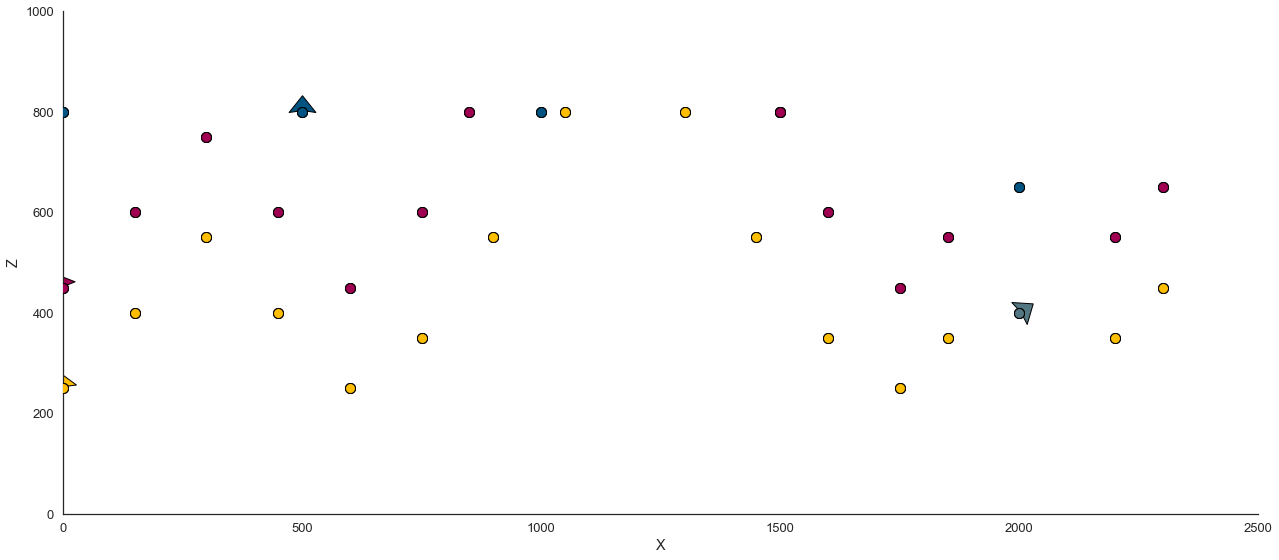

In [149]:
%matplotlib inline
gp.plot.plot_data(geo_data, direction='y')

In [150]:
interp_data = gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!


In [151]:
sol = gp.compute_model(geo_data)

In [152]:
#geo_data.add_topography(source='random')

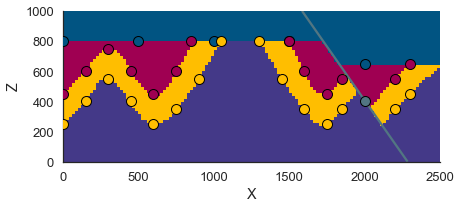

In [153]:
%matplotlib inline
gp.plot.plot_section(geo_data, cell_number=2,
                         direction='y', show_data=True)

# Kriging test

In [154]:
# conditioning data (data measured at locations)
cond_data = np.array([[100,.5,500,2],[900,.5,500,1],[500,.5,550,1],[300,.5,400,5]])

domain = kriging.domain(model=sol, domain=[4], data=cond_data)

variogram_model = kriging.variogram_model(theoretical_model = 'exponential', 
                                          range_=200, sill=np.var(cond_data[:,3]), nugget=0.1)

In [155]:
solution = kriging.create_kriged_field(domain, variogram_model)

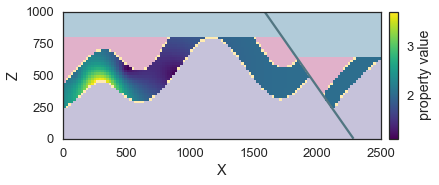

In [156]:
solution.plot_results(geo_data=geo_data, prop='val', contour=False, direction='y', cell_number=0, alpha=0.7,
                          show_data=False, legend=True)

# SGS non-eucl?

In [200]:
importlib.reload(kriging)

<module 'gempy.assets.kriging' from '../../..\\gempy\\assets\\kriging.py'>

In [201]:
domain = kriging.domain(model=sol, domain=[4], data=cond_data, fault=True)

In [202]:
# Manual way to input sgs stuff with scalar field values for non euclidian distance 
# nit nice but good enough for figure

geo_data.set_custom_grid(domain.data[:,:3])
gp.compute_model(geo_data, compute_mesh=False)

locs = np.hstack((domain.krig_grid, domain.krig_scal.reshape((len(domain.krig_grid),1)), domain.fault_model.reshape((len(domain.krig_grid),1))))
np.random.shuffle(locs)

sgs_locations = np.vstack((domain.data[:,:3], locs[:,:3]))
sgs_gradients = np.vstack((geo_data.solutions.custom[1][2].reshape((4,1)), locs[:,3].reshape((len(domain.krig_grid),1))))
sgs_fault_block = np.vstack((np.round(geo_data.solutions.custom[1][0].reshape((4,1))), locs[:,4].reshape((len(domain.krig_grid),1))))

sgs_grid = np.hstack((sgs_locations, sgs_gradients))
sol.grid.set_inactive('custom')

Active grids: ['regular' 'custom']


array([ True, False, False, False, False])

In [203]:
domain = kriging.domain(model=sol, domain=[4], data=cond_data, fault=True)

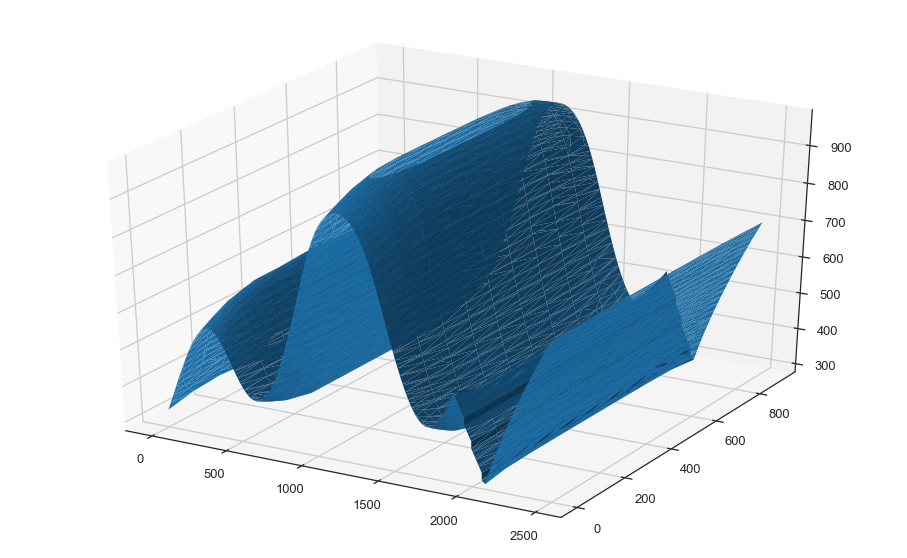

In [204]:
solution_sim = kriging.create_gaussian_field(domain, variogram_model, distance_type='deformed', 
                                             moving_neighbourhood='n_closest', sgs_grid=sgs_grid, shuffled_grid=locs,
                                            sgs_fault_block=sgs_fault_block)

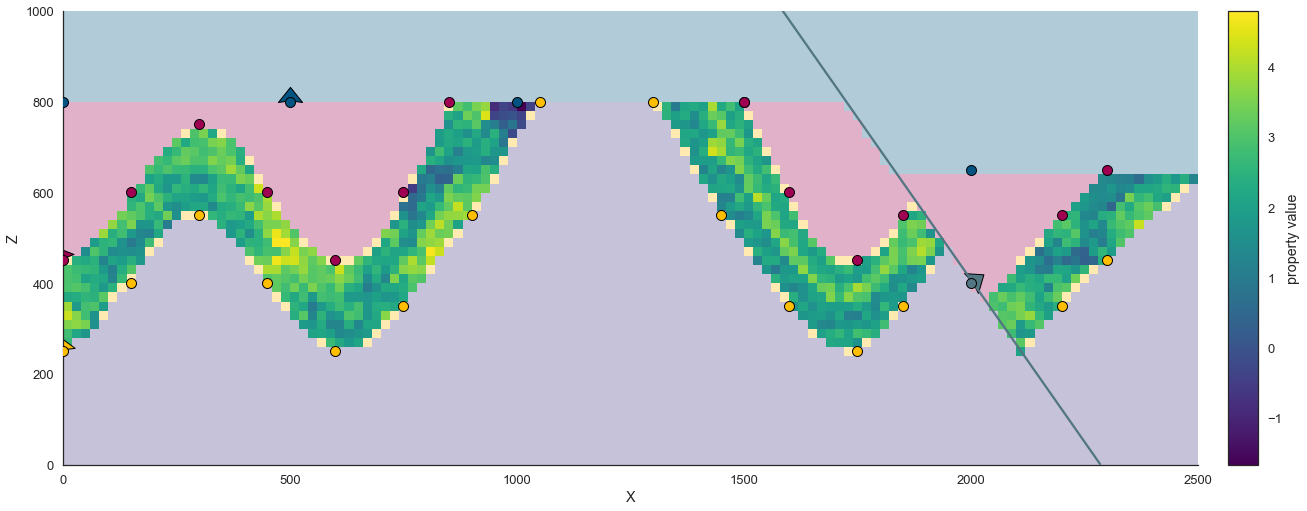

In [205]:
solution_sim.plot_results(geo_data=geo_data, prop='val', contour=False, direction='y', cell_number=5, alpha=0.7,
                          show_data=False, legend=True)

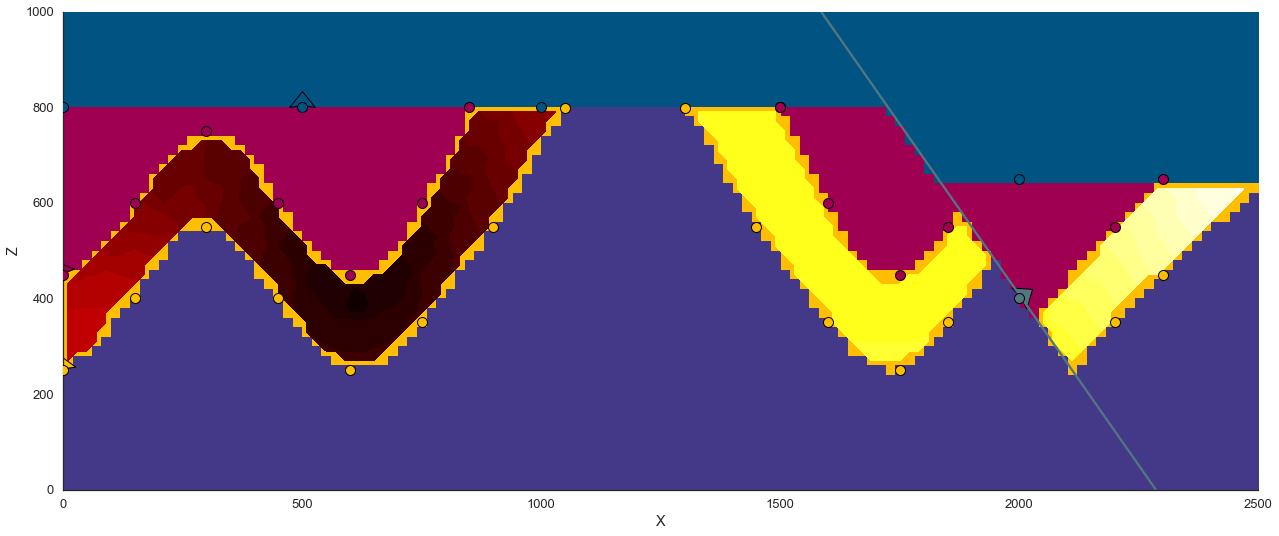

In [206]:
solution_sim.plot_distances(geo_data=geo_data, direction='y', cell_number=5, 
                            contour=True, alpha=0.7,  interpolation='bilinear')